In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod, ABC
from typing import Sequence, Optional, Callable, Literal

from numpy.typing import NDArray

np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [2]:
# def append_ones(matrix, axis=1):
#     return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)


def zeros(*dims: int) -> NDArray:
    return np.zeros(shape=tuple(dims), dtype=np.float32)


def ones(*dims: int) -> NDArray:
    return np.ones(shape=tuple(dims), dtype=np.float32)


def rand(*dims: int) -> NDArray:
    return np.random.rand(*dims).astype(np.float32)


def randn(*dims: int) -> NDArray:
    return np.random.randn(*dims).astype(np.float32)


def chunks(seq: NDArray, size: int):
    return (seq[pos : pos + size] for pos in range(0, len(seq), size))


def as_matrix(vector: NDArray) -> NDArray:
    return np.reshape(vector, (-1, 1))


def one_hot_encode(labels: NDArray) -> NDArray:
    one_hot = zeros(labels.shape[0], np.max(labels) + 1)
    one_hot[np.arange(labels.shape[0]), labels] = 1
    return one_hot.astype(np.float32)


def tiles(examples: NDArray):
    space = 2
    rows, cols, h, w = examples.shape

    img_matrix = np.empty(shape=(rows * (h + space) - space, cols * (h + space) - space))
    img_matrix.fill(np.nan)

    for r in range(rows):
        for c in range(cols):
            x_0 = r * (h + space)
            y_0 = c * (w + space)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0 : x_0 + h, y_0 : y_0 + w] = (examples[r, c] - ex_min) / (ex_max - ex_min)

    plt.matshow(img_matrix, cmap="gray", interpolation="none")
    plt.axis("off")
    plt.show()

### Activation functions

In [3]:
def sigmoid(x: NDArray, sample: bool) -> NDArray:
    σ = 1.0 / (1.0 + np.exp(-x))
    if sample:
        return σ > rand(*σ.shape)
    return σ


def softmax(x: NDArray) -> NDArray:
    m = x.max(axis=1, keepdims=True)
    y = np.exp(x - m)
    return y / y.sum(axis=1, keepdims=True)

# MNIST dataset

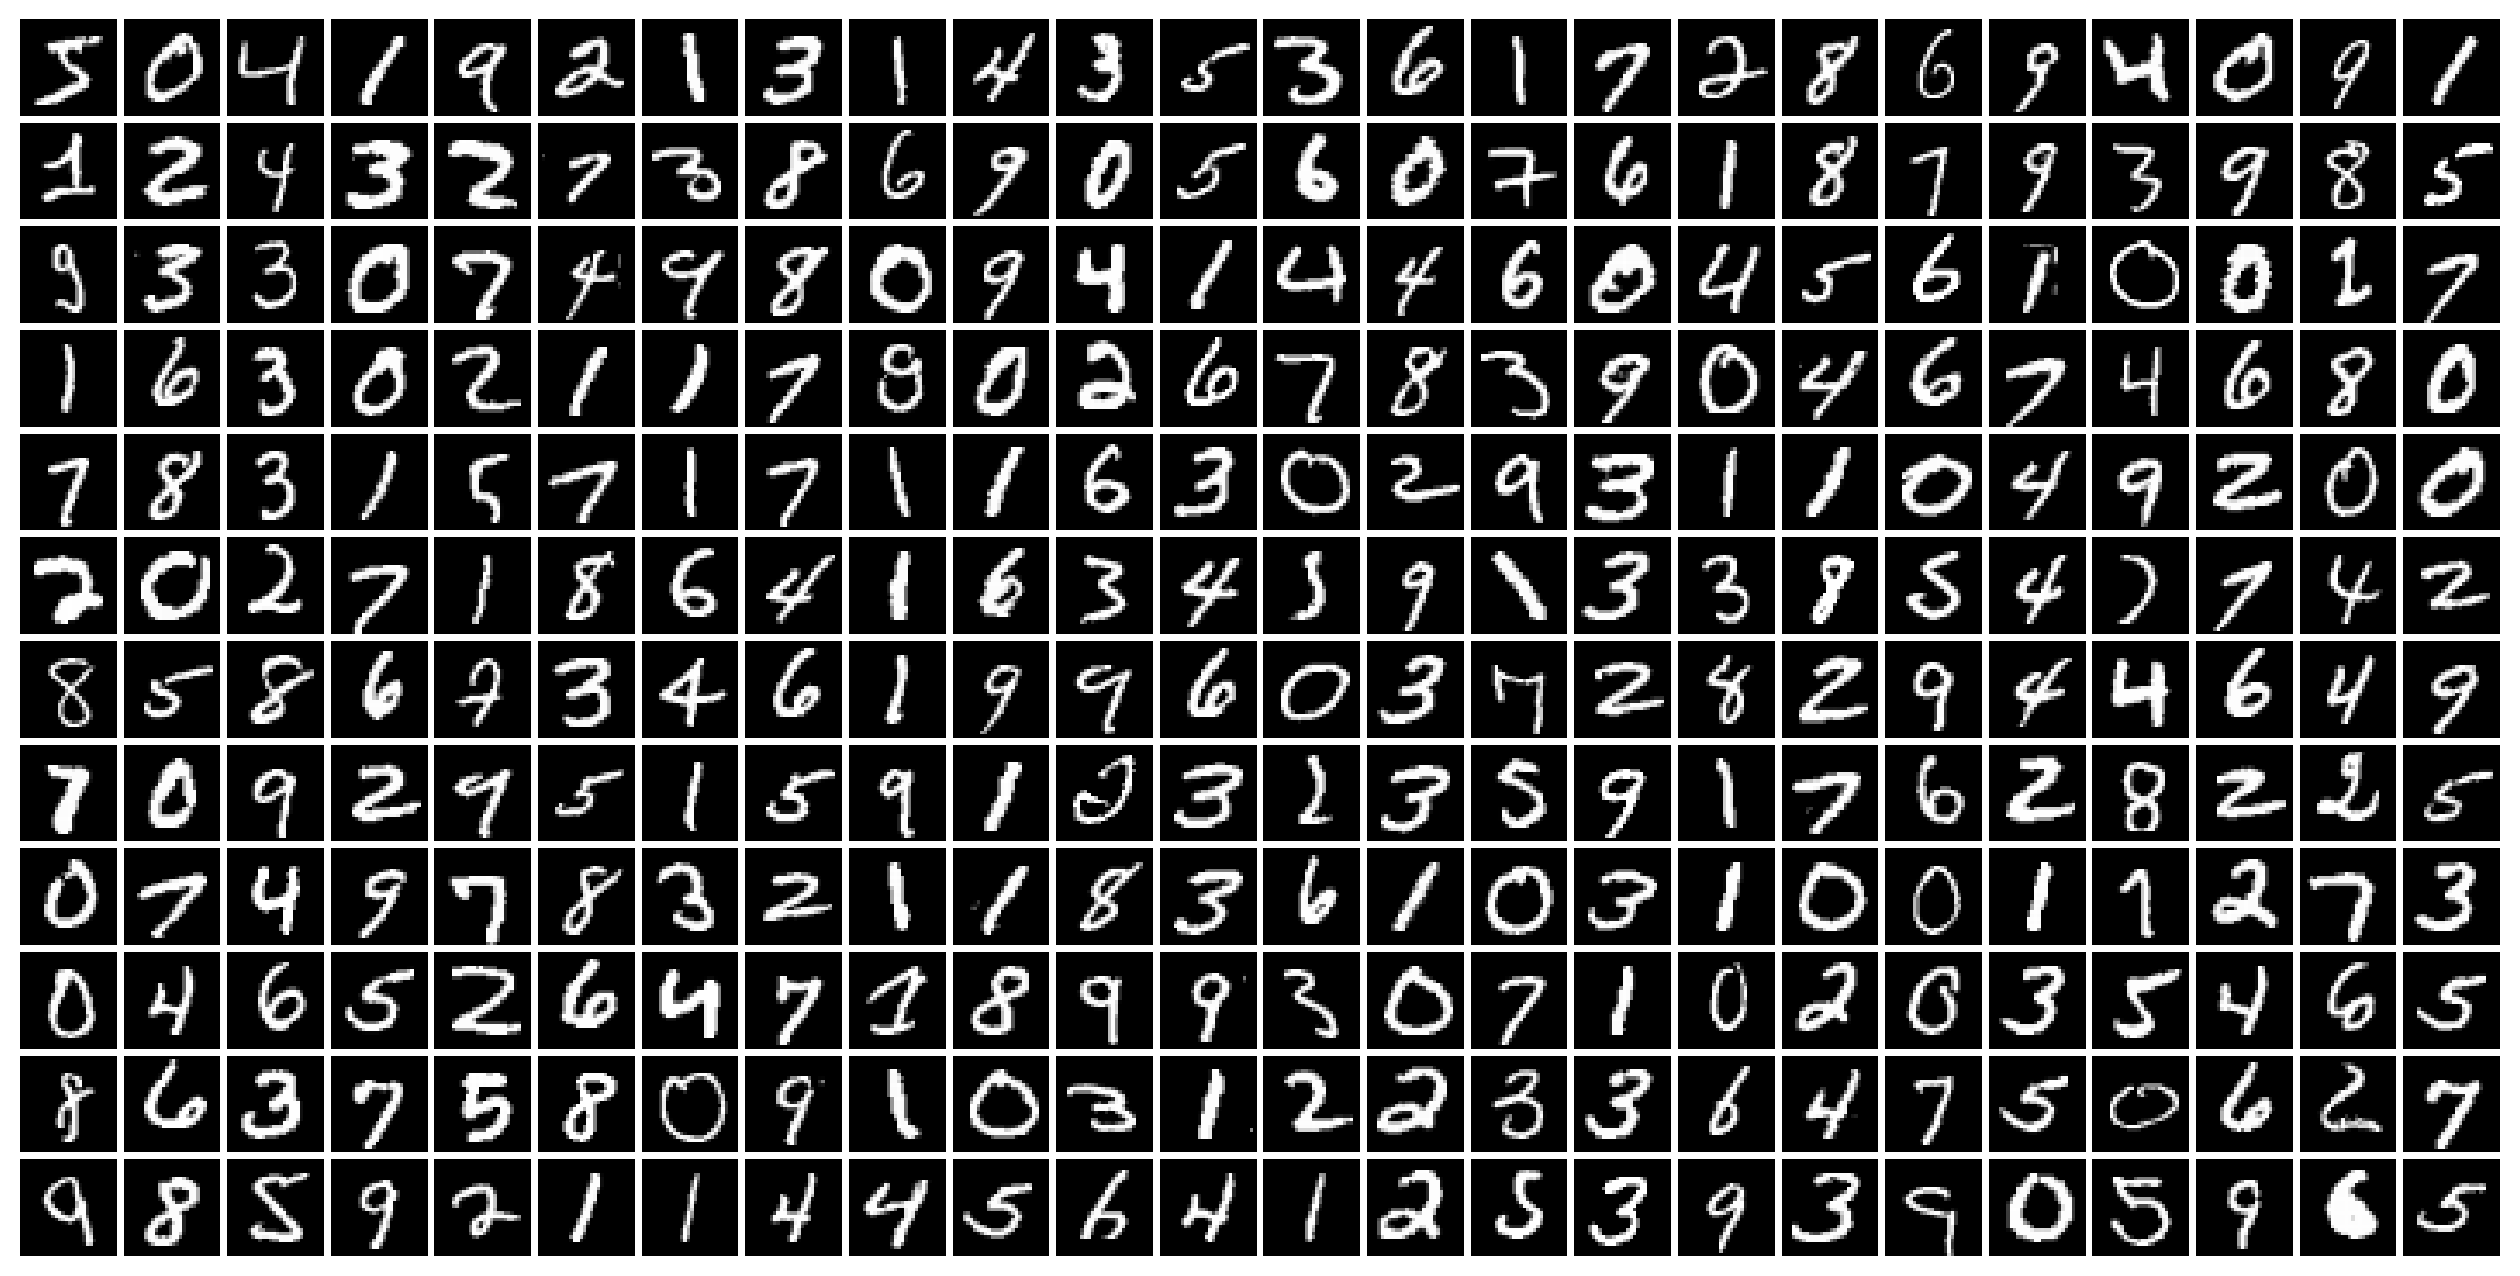

In [4]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

# ReLU and Max-Norm regularization

In [5]:
def relu(x: NDArray, sample: bool) -> NDArray:
    if sample:
        return np.maximum(0, x + sigmoid(x, sample=False) * randn(*x.shape))
    return np.maximum(0, x)

In [6]:
def limit_weights(w: NDArray, λ: float) -> NDArray:
    if λ == 0:
        return w
    norm = np.linalg.norm(w, ord=2, axis=0)
    mask = norm > λ
    ρ = mask * (λ / norm) + (~mask) * 1.0
    return w * ρ

# RBM & DBN training

In [7]:
class RBM:
    def __init__(
        self,
        vsize: int,
        hsize: int,
        v_activation: Callable[[NDArray, bool], NDArray],
        h_activation: Callable[[NDArray, bool], NDArray],
        lr: float,
        momentum: float,
        weight_limit: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize = vsize
        self.hsize = hsize
        self.v_activation = v_activation
        self.h_activation = h_activation

        # Training hyper-params
        self.lr = lr
        self.momentum = momentum
        self.weight_limit = weight_limit

        # Initialize
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # Bias initialization
        self.b = zeros(self.vsize)
        self.c = zeros(self.hsize)

        # Velocity (momentum) tensor initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.vsize)
        self.m_c = zeros(self.hsize)

    def probas_v(self, h: NDArray, sample: bool) -> NDArray:
        return self.v_activation(self.b + h @ self.w.T, sample=sample)

    def probas_h(self, v: NDArray, sample: bool) -> NDArray:
        return self.h_activation(self.c + v @ self.w, sample=sample)

    def sample(self, v: NDArray, steps: int) -> NDArray:
        # --- Gibbs sampling
        for k in range(steps):
            h = self.probas_h(v, sample=True)
            v = self.probas_v(h, sample=(k < steps - 1))
        return v

In [8]:
def reconstuction_error(rbm: RBM, v: NDArray) -> float:
    batch_size = v.shape[0]
    σ = rbm.sample(v, steps=1)
    return 1 / batch_size * np.sum((v - σ) ** 2)

In [9]:
def draw_rbm_filters(rbm: RBM):
    filters = rbm.w.T
    filters = filters.reshape(8, -1, 28, 28)
    # filters = np.clip(filters, -1, +1)
    tiles(filters)

In [10]:
def cdk(rbm: RBM, minibatch: NDArray, k: int = 1):
    batch_size = minibatch.shape[0]
    v = minibatch

    # Compute gradients
    # -----------------

    # Positive phase
    σ = rbm.probas_h(v, sample=False)

    grad_w = -1 / batch_size * (v.T @ σ)
    grad_b = -1 / batch_size * (v.sum(axis=0))
    grad_c = -1 / batch_size * (σ.sum(axis=0))

    # Negative phase

    # --- Gibbs sampling
    h = rbm.probas_h(v, sample=True)
    v = rbm.probas_v(h, sample=True)
    for _ in range(k - 1):
        h = rbm.probas_h(v, sample=True)
        v = rbm.probas_v(h, sample=True)

    # --- Negative gradient estimation
    σ = rbm.probas_h(v, sample=False)

    grad_w += 1 / batch_size * (v.T @ σ)
    grad_b += 1 / batch_size * (v.sum(axis=0))
    grad_c += 1 / batch_size * (σ.sum(axis=0))

    # Update params
    # -------------
    rbm.m_w = rbm.momentum * rbm.m_w - rbm.lr * grad_w
    rbm.m_b = rbm.momentum * rbm.m_b - rbm.lr * grad_b
    rbm.m_c = rbm.momentum * rbm.m_c - rbm.lr * grad_c

    rbm.w += rbm.m_w
    rbm.b += rbm.m_b
    rbm.c += rbm.m_c

    # --- Apply weight limit normalization
    rbm.w = limit_weights(rbm.w, rbm.weight_limit)

In [11]:
# (POSSIBLE)BUG: Why is there sigmoid function if we use different activations now?
# def propagate_up(dbn, layers_count, visible):
#     for i in range(layers_count):
#         visible = append_ones(sigmoid(visible @ dbn[i].W[:, :-1]))
#     return visible


# def propagate_down(dbn, layers_count, hidden):
#     for i in reversed(range(layers_count)):
#         hidden = append_ones(sigmoid(hidden @ np.transpose(dbn[i].W[:-1, :])))
#     return hidden


def propagate_up(dbn: Sequence[RBM], n_layers: int, v: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in range(n_layers):
        v = dbn[i].probas_h(v, sample=False)
    return v


def propagate_dn(dbn: Sequence[RBM], n_layers: int, h: NDArray) -> NDArray:
    assert 0 <= n_layers < len(dbn)
    for i in reversed(range(n_layers)):
        h = dbn[i].probas_v(h, sample=False)
    return h


def dbn_reconstuction_error(dbn: Sequence[RBM], n_layers: int, minibatch: NDArray) -> float:
    assert 0 <= n_layers < len(dbn)
    visible = propagate_up(dbn, n_layers, minibatch)
    return reconstuction_error(dbn[n_layers], visible)


def train_dbn_layer(dbn: Sequence[RBM], layer_idx: int, dataset: NDArray, batch_size: int):
    dataset = propagate_up(dbn, layer_idx, dataset)
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")


def run_dbn_training(
    dbn: Sequence[RBM],
    dataset: NDArray,
    monitoring_set: NDArray,
    batch_size: int,
    epochs_count: int,
    target_momentum: float = 0.9,
):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx + 1))

        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch + 1), end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = target_momentum

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

# MLP training

In [12]:
class Layer(ABC):
    # Outputs of the layer after forward pass
    y: Optional[NDArray]

    @abstractmethod
    def reset(self, *args, **kwargs):
        """Initialize the layer."""
        raise NotImplementedError

    @abstractmethod
    def forward(self, x: NDArray, training: bool) -> NDArray:
        """Propagate the input `x` forward through the layer and save the output in `self.y`."""
        raise NotImplementedError

    @abstractmethod
    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        """
        Given layer input `x` and ∂Loss/∂y (`grad_y`)
            * compute ∂Loss/∂x and ∂Loss/∂θ (where θ are the layer's params;
            * update parameters using (momentum) SGD;
            * return ∂Loss/∂x;

        NOTE: We assume that the layers are connected in a simple path (i.e. the computation graph
        is linear) and thus we don't have to keep and accumulate the gradients ∂Loss/∂y in the layer
        itself, but can instead just dynamically pass ∂Loss/∂y while traversing this linear
        computation graph.
        """
        raise NotImplementedError

In [13]:
class Sigmoid(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = 1.0 / (1.0 + np.exp(-x))
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (self.y * (1.0 - self.y))
        # --- Propagate ∂Loss/∂x backward
        return grad_x


class ReLU(Layer):
    def __init__(self):
        self.reset()

    def reset(self):
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = np.maximum(0, x)
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y * (x > 0).astype(np.float32)
        # --- Propagate ∂Loss/∂x backward
        return grad_x

In [14]:
class Linear(Layer):
    def __init__(
        self,
        vsize: int,
        hsize: int,
        lr: float,
        momentum: float,
        weight_limit: float,
        init_method: Literal["Xavier", "He"],
    ):
        self.vsize: int = vsize
        self.hsize: int = hsize
        self.lr: float = lr
        self.momentum: float = momentum
        self.weight_limit: float = weight_limit
        self.init_method = init_method
        self.reset()

    def reset(self):
        # Weights initialization
        match self.init_method:
            case "Xavier":
                scale = np.sqrt(6 / (self.vsize + self.hsize))
                self.w = np.random.uniform(-scale, +scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case "He":
                scale = np.sqrt(4 / (self.vsize + self.hsize))
                self.w = np.random.normal(0, scale, size=(self.vsize, self.hsize)).astype(np.float32)
            case _:
                raise ValueError(f"Unrecognised `init_method`: {self.init_method}")

        # NOTE: Interesting observation: when using one of the above initialization methods (which
        # have good theoretical foundations) the filters of the plain MLPs are much noisier and do
        # not represent well defined shapes/curves but the performance is (marginally) better. When
        # using the ad hoc initialization as below we get sligthly worse performance but the filters
        # represent well defined shapes/curves.

        # self.w = np.random.normal(0, 0.01, size=(self.vsize, self.hsize)).astype(np.float32)

        # Biases initialization
        self.b = zeros(self.hsize)

        # Velocity (momentum) tensors initialization
        self.m_w = zeros(self.vsize, self.hsize)
        self.m_b = zeros(self.hsize)

        # Outputs
        self.y: Optional[NDArray] = None

    def forward(self, x: NDArray, training: bool) -> NDArray:
        self.y = self.b + x @ self.w
        return self.y

    def backward(self, x: NDArray, grad_y: NDArray) -> NDArray:
        # --- Compute ∂Loss/∂x
        grad_x = grad_y @ self.w.T

        # --- Compute ∂Loss/∂w and ∂Loss/∂b
        grad_w = x.T @ grad_y
        grad_b = grad_y.sum(axis=0)

        # --- Update params
        self.m_w = self.momentum * self.m_w - self.lr * grad_w
        self.m_b = self.momentum * self.m_b - self.lr * grad_b

        self.w += self.m_w
        self.b += self.m_b

        # --- Apply weight limit normalization
        self.w = limit_weights(self.w, self.weight_limit)

        # --- Propagate ∂Loss/∂x backward
        return grad_x

### Forward pass

In [15]:
def forward_pass(mlp: Sequence[Layer], x: NDArray, training: bool) -> NDArray:
    for layer in mlp:
        x = layer.forward(x, training=training)
    return x

### Error backpropagation

In [16]:
def error_backpropagate(mlp: Sequence[Layer], X_batch: NDArray, grad_y: NDArray):
    for i in reversed(range(len(mlp))):
        # --- Get input to the i-th layer i.e. output of the (i-1)-th layer (or `X_batch` if i=0)
        x = mlp[i - 1].y if i > 0 else X_batch
        # --- Propagate the ∂Loss/∂y backward through layer `i` and update params
        grad_y = mlp[i].backward(x, grad_y)

### Training procedure

In [17]:
def classify(mlp: Sequence[Layer], X_batch: NDArray) -> NDArray:
    mlogits = forward_pass(mlp, X_batch, training=False)
    return np.argmax(mlogits, axis=1)


def draw_layer_filters(layer: Linear):
    filters = layer.w.T
    filters = filters.reshape(8, -1, 28, 28)
    tiles(filters)

In [18]:
def train_mlp(mlp: Sequence[Layer], dataset: NDArray, labels: NDArray, batch_size: int):
    batches_limit = dataset.shape[0] / batch_size

    batched_data = chunks(dataset, batch_size)
    batched_labels = chunks(labels, batch_size)

    for batch_idx, (X_batch, t_batch) in enumerate(zip(batched_data, batched_labels)):
        # Forward pass: compute activatations and derivatives of activations
        # NOTE: in this implementation mlp returns *mlogits* and not probabilities
        y = forward_pass(mlp, X_batch, training=True)

        # Compute ∂Loss/∂y for the last layer i.e. the output of the whole network assuming the loss
        # function is the cross entropy function.
        # NOTE: in this implementation mlp returns *mlogits* and thus we need to pass `y` through
        # the softmax function to compute the appropriate gradients.
        grad_y = 1 / len(X_batch) * (softmax(y) - t_batch)

        # Once softmax deltas are set, we may backpropagate errors
        error_backpropagate(mlp, X_batch, grad_y)

        if batch_idx % round(batches_limit / 40) == 0:
            print("#", end="")

In [19]:
def run_mlp_training(
    mlp: Sequence[Layer],
    X_train: NDArray,
    y_train: NDArray,
    X_valid: NDArray,
    y_valid: NDArray,
    batch_size: int,
    epochs_count: int,
    target_momentum: float = 0.95,
):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch + 1), end="\t")

        if epoch == 5:
            for layer in filter(lambda l: isinstance(l, Linear), mlp):
                layer.momentum = target_momentum

        start_time = time.time()
        train_mlp(mlp, X_train, y_train, batch_size)
        elapsed = time.time() - start_time

        predictions = classify(mlp, X_valid)
        accuracy = np.sum(predictions == y_valid) / predictions.shape[0]
        print("\telapsed: {0:>2.2f}s, accuracy: {1:>2.2%}".format(elapsed, accuracy))

    print("Training finished!")

#  Initializing MLP with DBN weights

Implement initialization of MLP weights (and biases) using weights (and biases) from the DBN layers.

Make sure that the MLP weights (and biases) are **copies** of the DBN weights (and biases). You can use ```np.copy(...)``` function to copy the weights (simple assignment will make a view instead of a copy).

In [20]:
def initialize_mlp(mlp: Sequence[Layer], dbn: Sequence[RBM]):
    linear_layers = [layer for layer in mlp if isinstance(layer, Linear)]
    for layer, rbm in zip(linear_layers, dbn):
        layer.w = rbm.w.copy()
        layer.b = rbm.c.copy()

# MNIST digits classification

In [21]:
DATASET_SIZE = 60_000  # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_labels = mnist.train_labels()

order = np.random.permutation(len(mnist_train_images))
mnist_train_images = mnist_train_images[order]
mnist_train_labels = mnist_train_labels[order]

mnist_train_images = mnist_train_images[:DATASET_SIZE]
mnist_train_images = mnist_train_images.reshape(DATASET_SIZE, DIGIT_SIZE * DIGIT_SIZE)
# mnist_train_images = append_ones(mnist_train_images)

mnist_train_labels = mnist_train_labels[:DATASET_SIZE]
mnist_train_labels = one_hot_encode(mnist_train_labels)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = mnist_test_images.reshape(-1, DIGIT_SIZE * DIGIT_SIZE)
# mnist_test_images = append_ones(mnist_test_images)

mnist_test_labels = mnist.test_labels()

In [22]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE
HIDDEN_LAYER_SIZE = 256

BATCH_SIZE = 128
EPOCHS_COUNT = 50

MLP_LEARNING_RATE = 0.03
SOFTMAX_LEARNING_RATE = 0.15
RBM_LEARNING_RATE = 0.003
MOMENTUM = 0.5

### Plain vs pretrained comparison

In [23]:
from IPython.core.display import HTML

def compare_pretraining_results(mlp, dbn,
                                train_set, train_labels,
                                validation_set, validation_labels,
                                monitoring_set,
                                batch_size, epochs_count):
    for layer in mlp:
        layer.reset()

    display(HTML('<h3>Plain MLP training</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>Input layer filters in the plain MLP</h3>'))
    draw_layer_filters(mlp[0])
    
    display(HTML('<h3>Largest norms of weight-vectors in the plain MLP layers</h3>'))
    for i, layer in enumerate(filter(lambda l: isinstance(l, Linear), mlp)):
        max_norm = np.max(np.linalg.norm(layer.w, axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))
    
    display(HTML('<h3>DBN training</h3>'))
    run_dbn_training(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    for layer in mlp:
        layer.reset()
    
    initialize_mlp(mlp, dbn)
    
    display(HTML('<h3>Finetuning pretrained MLP</h3>'))
    run_mlp_training(mlp,
                     train_set, train_labels,
                     validation_set, validation_labels,
                     batch_size, epochs_count)
    
    display(HTML('<h3>First layer filters in the DBN</h3>'))
    draw_rbm_filters(dbn[0])
    
    display(HTML('<h3>Input layer filters in the pretrained & finetuned MLP</h3>'))
    draw_layer_filters(mlp[0])

    display(HTML('<h3>Largest norms of weight-vectors in the finetuned MLP layers</h3>'))
    for i, layer in enumerate(filter(lambda l: isinstance(l, Linear), mlp)):
        max_norm = np.max(np.linalg.norm(layer.w, axis=0))
        print('\tlayer {0}: {1:.2f}'.format(i+1, max_norm))

### Shallow ReLU network

Epoch 1:	########################################	elapsed: 2.79s, accuracy: 93.28%
Epoch 2:	########################################	elapsed: 2.08s, accuracy: 95.12%
Epoch 3:	########################################	elapsed: 2.26s, accuracy: 95.98%
Epoch 4:	########################################	elapsed: 2.06s, accuracy: 96.28%
Epoch 5:	########################################	elapsed: 2.27s, accuracy: 96.55%
Epoch 6:	########################################	elapsed: 2.75s, accuracy: 96.73%
Epoch 7:	########################################	elapsed: 2.63s, accuracy: 97.37%
Epoch 8:	########################################	elapsed: 2.57s, accuracy: 97.24%
Epoch 9:	########################################	elapsed: 2.36s, accuracy: 97.06%
Epoch 10:	########################################	elapsed: 2.03s, accuracy: 97.64%
Epoch 11:	########################################	elapsed: 2.09s, accuracy: 97.72%
Epoch 12:	########################################	elapsed: 2.28s, accuracy: 97.88%
E

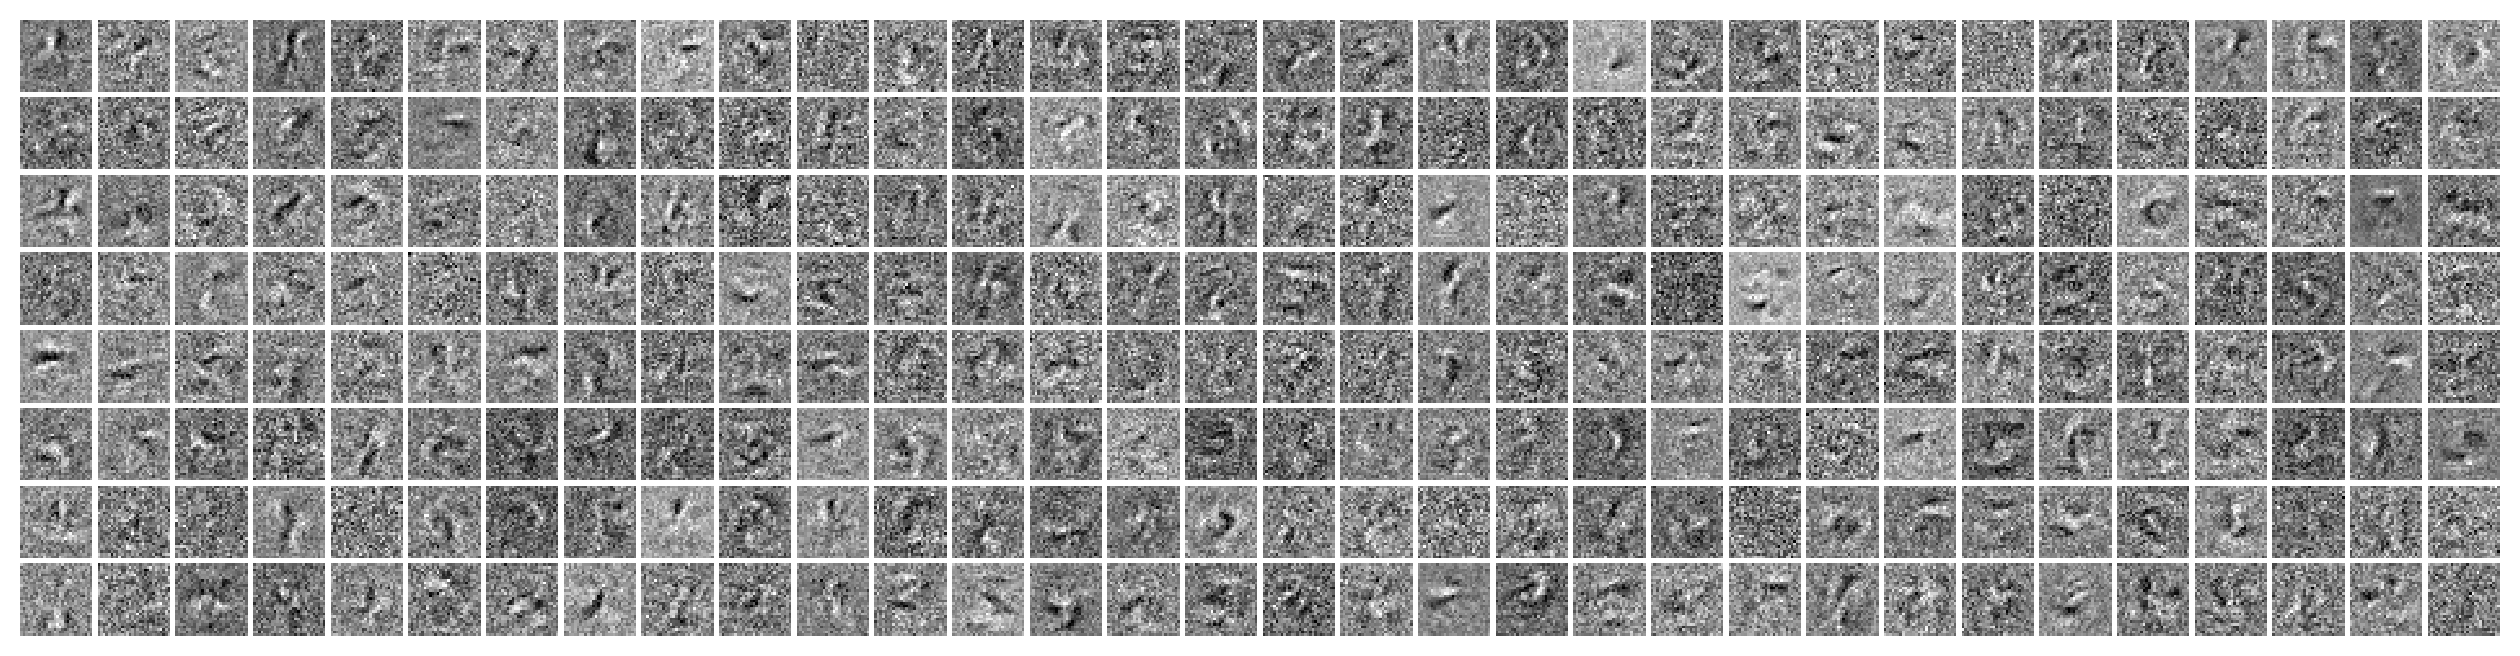

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 4.00



Learning layer 1
Epoch 1:	########################################	elapsed: 2.52s, reconstruction error: 23.43
Epoch 2:	########################################	elapsed: 2.47s, reconstruction error: 18.06
Epoch 3:	########################################	elapsed: 2.20s, reconstruction error: 15.74
Epoch 4:	########################################	elapsed: 2.40s, reconstruction error: 14.34
Epoch 5:	########################################	elapsed: 2.85s, reconstruction error: 13.37
Epoch 6:	########################################	elapsed: 2.92s, reconstruction error: 10.74
Epoch 7:	########################################	elapsed: 4.36s, reconstruction error: 9.35
Epoch 8:	########################################	elapsed: 2.57s, reconstruction error: 8.67
Epoch 9:	########################################	elapsed: 3.37s, reconstruction error: 8.35
Epoch 10:	########################################	elapsed: 2.73s, reconstruction error: 8.19
Epoch 11:	###################################

Epoch 1:	########################################	elapsed: 1.55s, accuracy: 97.35%
Epoch 2:	########################################	elapsed: 3.66s, accuracy: 97.35%
Epoch 3:	########################################	elapsed: 1.36s, accuracy: 97.74%
Epoch 4:	########################################	elapsed: 1.44s, accuracy: 98.13%
Epoch 5:	########################################	elapsed: 1.32s, accuracy: 98.02%
Epoch 6:	########################################	elapsed: 1.35s, accuracy: 98.11%
Epoch 7:	########################################	elapsed: 1.39s, accuracy: 98.36%
Epoch 8:	########################################	elapsed: 1.43s, accuracy: 98.44%
Epoch 9:	########################################	elapsed: 1.41s, accuracy: 98.57%
Epoch 10:	########################################	elapsed: 1.31s, accuracy: 98.46%
Epoch 11:	########################################	elapsed: 1.33s, accuracy: 98.47%
Epoch 12:	########################################	elapsed: 1.27s, accuracy: 98.66%
E

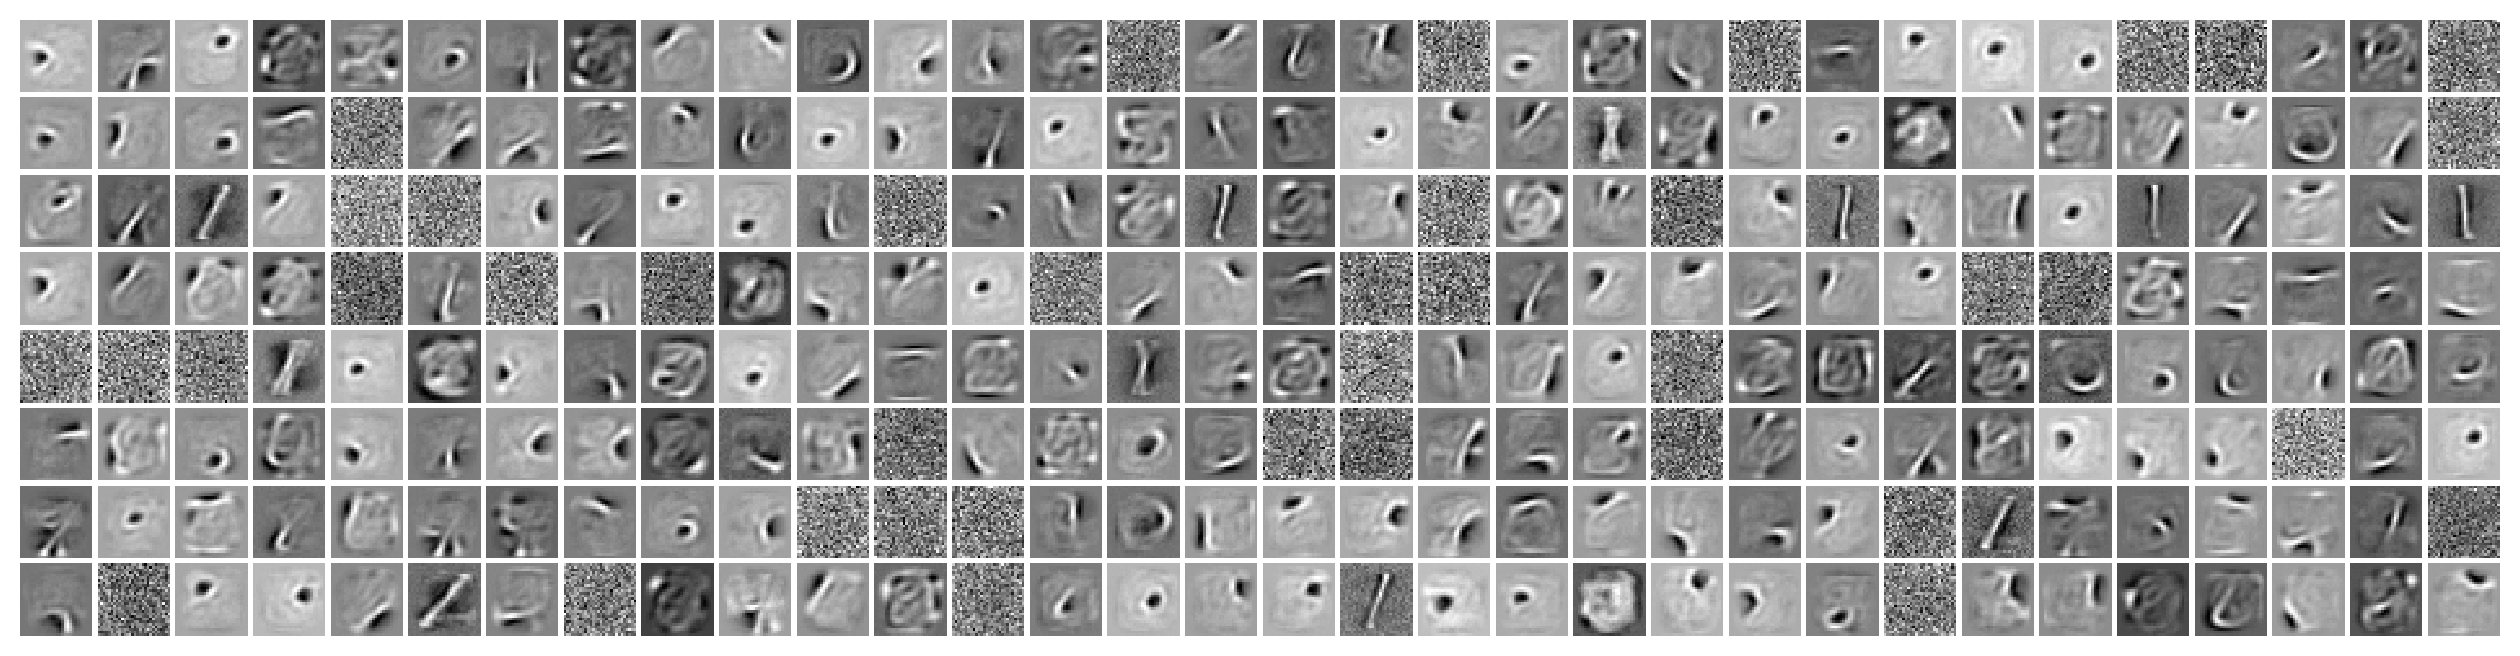

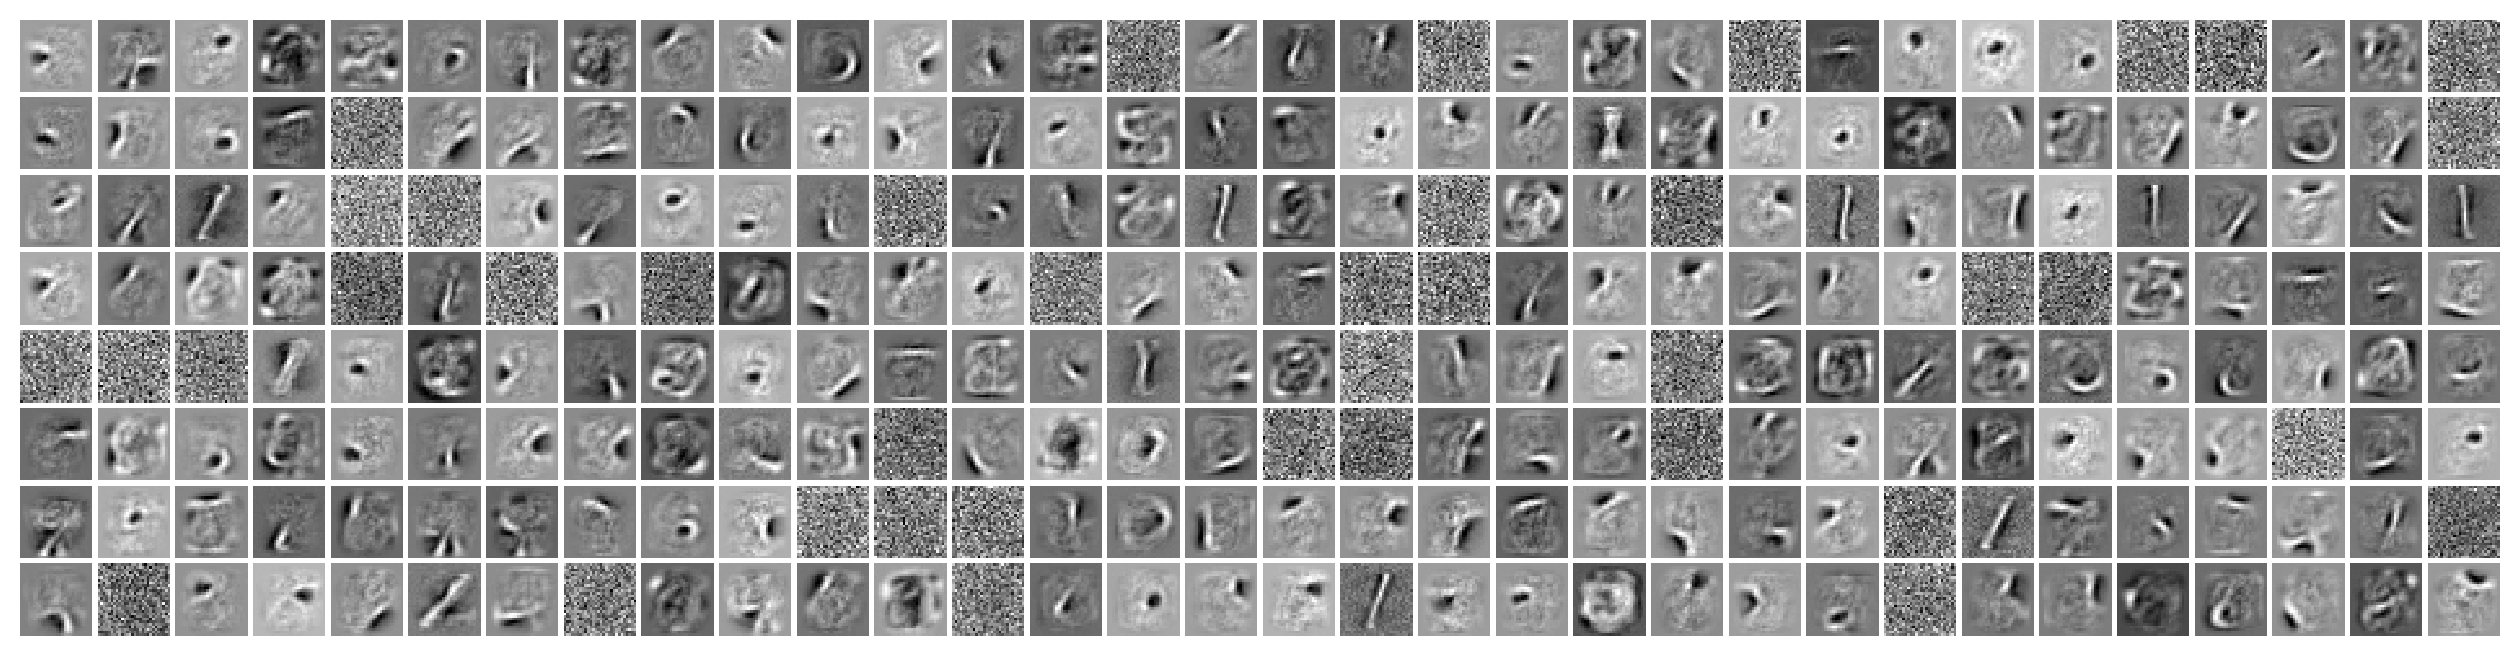

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 4.00


In [24]:
shallow_mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, MLP_LEARNING_RATE, MOMENTUM, weight_limit=2.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, MLP_LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0, init_method="He"),
]

shallow_dbn = [
    RBM(
        VISIBLE_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        relu,
        RBM_LEARNING_RATE,
        MOMENTUM,
        weight_limit=2.0,
        init_method="He",
    ),
    RBM(
        HIDDEN_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        relu,
        relu,
        RBM_LEARNING_RATE,
        MOMENTUM,
        weight_limit=1.0,
        init_method="He",
    ),
]

compare_pretraining_results(
    shallow_mlp,
    shallow_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)

### Deep ReLU network

Epoch 1:	########################################	elapsed: 3.33s, accuracy: 93.97%
Epoch 2:	########################################	elapsed: 2.73s, accuracy: 95.58%
Epoch 3:	########################################	elapsed: 2.89s, accuracy: 96.35%
Epoch 4:	########################################	elapsed: 2.55s, accuracy: 96.84%
Epoch 5:	########################################	elapsed: 2.97s, accuracy: 97.04%
Epoch 6:	########################################	elapsed: 2.72s, accuracy: 96.84%
Epoch 7:	########################################	elapsed: 6.63s, accuracy: 97.26%
Epoch 8:	########################################	elapsed: 3.44s, accuracy: 97.00%
Epoch 9:	########################################	elapsed: 4.30s, accuracy: 97.06%
Epoch 10:	########################################	elapsed: 3.37s, accuracy: 97.95%
Epoch 11:	########################################	elapsed: 3.01s, accuracy: 97.79%
Epoch 12:	########################################	elapsed: 3.28s, accuracy: 97.75%
E

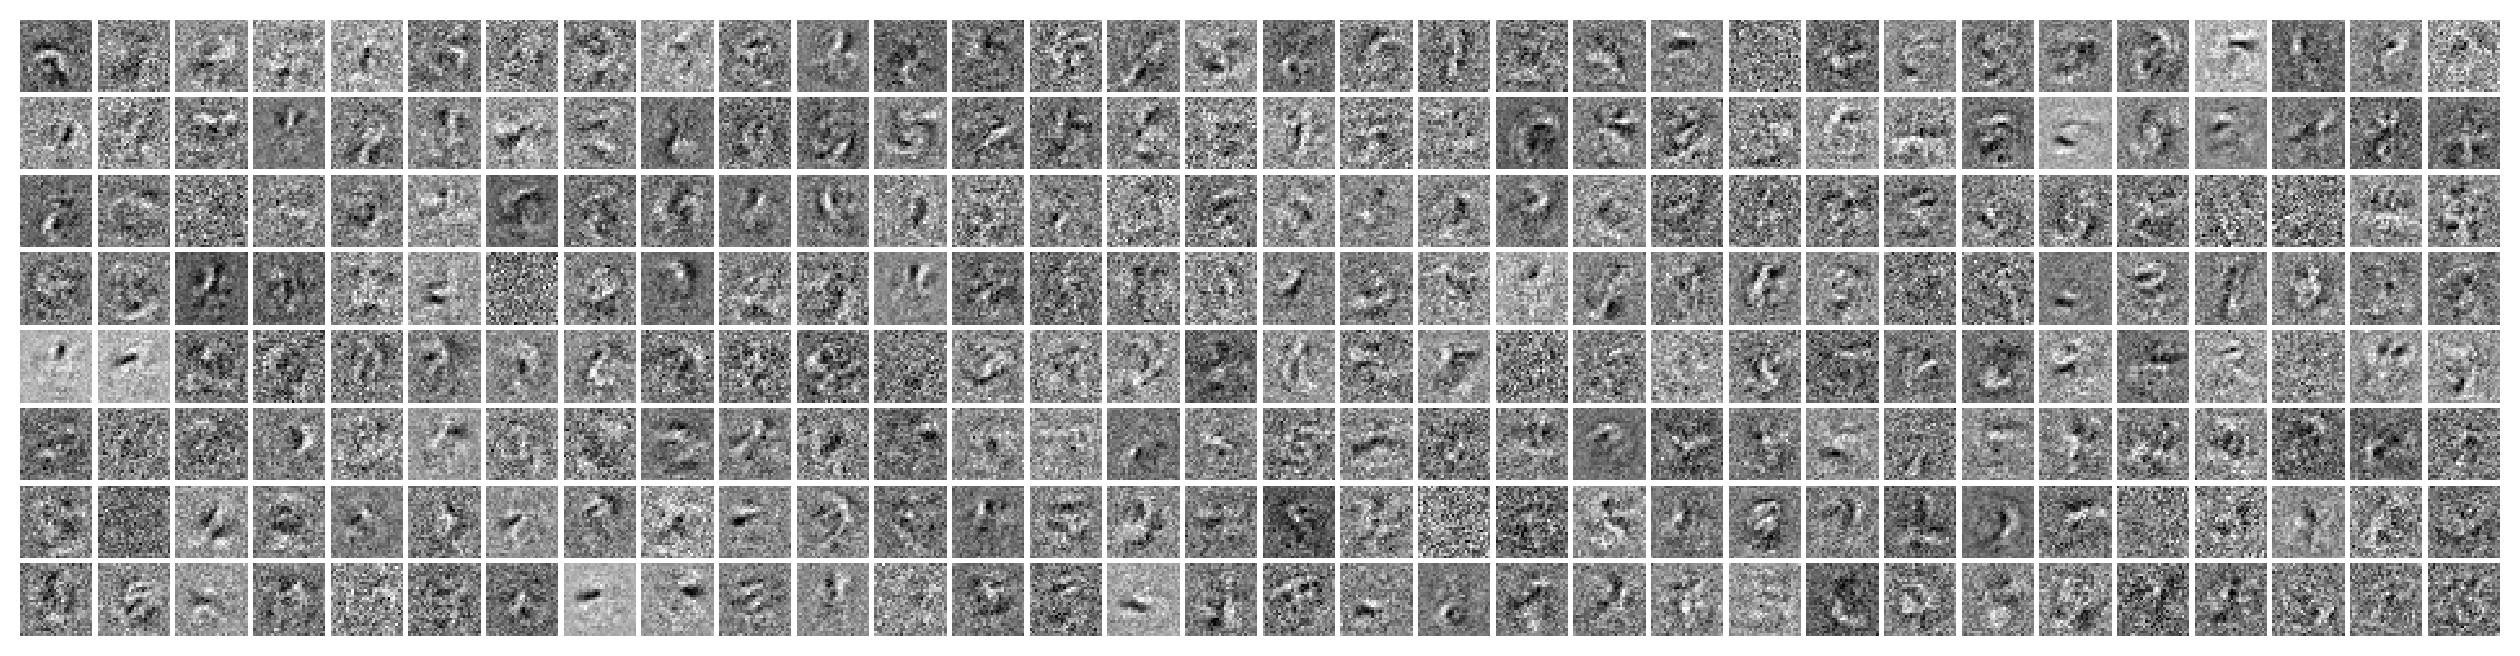

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 1.00
	layer 4: 4.00



Learning layer 1
Epoch 1:	########################################	elapsed: 3.31s, reconstruction error: 23.92
Epoch 2:	########################################	elapsed: 2.61s, reconstruction error: 18.34
Epoch 3:	########################################	elapsed: 2.71s, reconstruction error: 15.93
Epoch 4:	########################################	elapsed: 2.72s, reconstruction error: 14.43
Epoch 5:	########################################	elapsed: 2.81s, reconstruction error: 13.41
Epoch 6:	########################################	elapsed: 5.09s, reconstruction error: 10.72
Epoch 7:	########################################	elapsed: 3.41s, reconstruction error: 9.34
Epoch 8:	########################################	elapsed: 3.07s, reconstruction error: 8.68
Epoch 9:	########################################	elapsed: 3.15s, reconstruction error: 8.43
Epoch 10:	########################################	elapsed: 3.34s, reconstruction error: 8.25
Epoch 11:	###################################

Epoch 1:	########################################	elapsed: 2.46s, accuracy: 97.27%
Epoch 2:	########################################	elapsed: 2.71s, accuracy: 97.78%
Epoch 3:	########################################	elapsed: 2.75s, accuracy: 98.08%
Epoch 4:	########################################	elapsed: 2.34s, accuracy: 98.16%
Epoch 5:	########################################	elapsed: 2.31s, accuracy: 98.14%
Epoch 6:	########################################	elapsed: 3.16s, accuracy: 98.17%
Epoch 7:	########################################	elapsed: 2.34s, accuracy: 98.01%
Epoch 8:	########################################	elapsed: 3.46s, accuracy: 98.57%
Epoch 9:	########################################	elapsed: 2.77s, accuracy: 98.54%
Epoch 10:	########################################	elapsed: 4.82s, accuracy: 98.49%
Epoch 11:	########################################	elapsed: 2.24s, accuracy: 98.51%
Epoch 12:	########################################	elapsed: 2.17s, accuracy: 98.54%
E

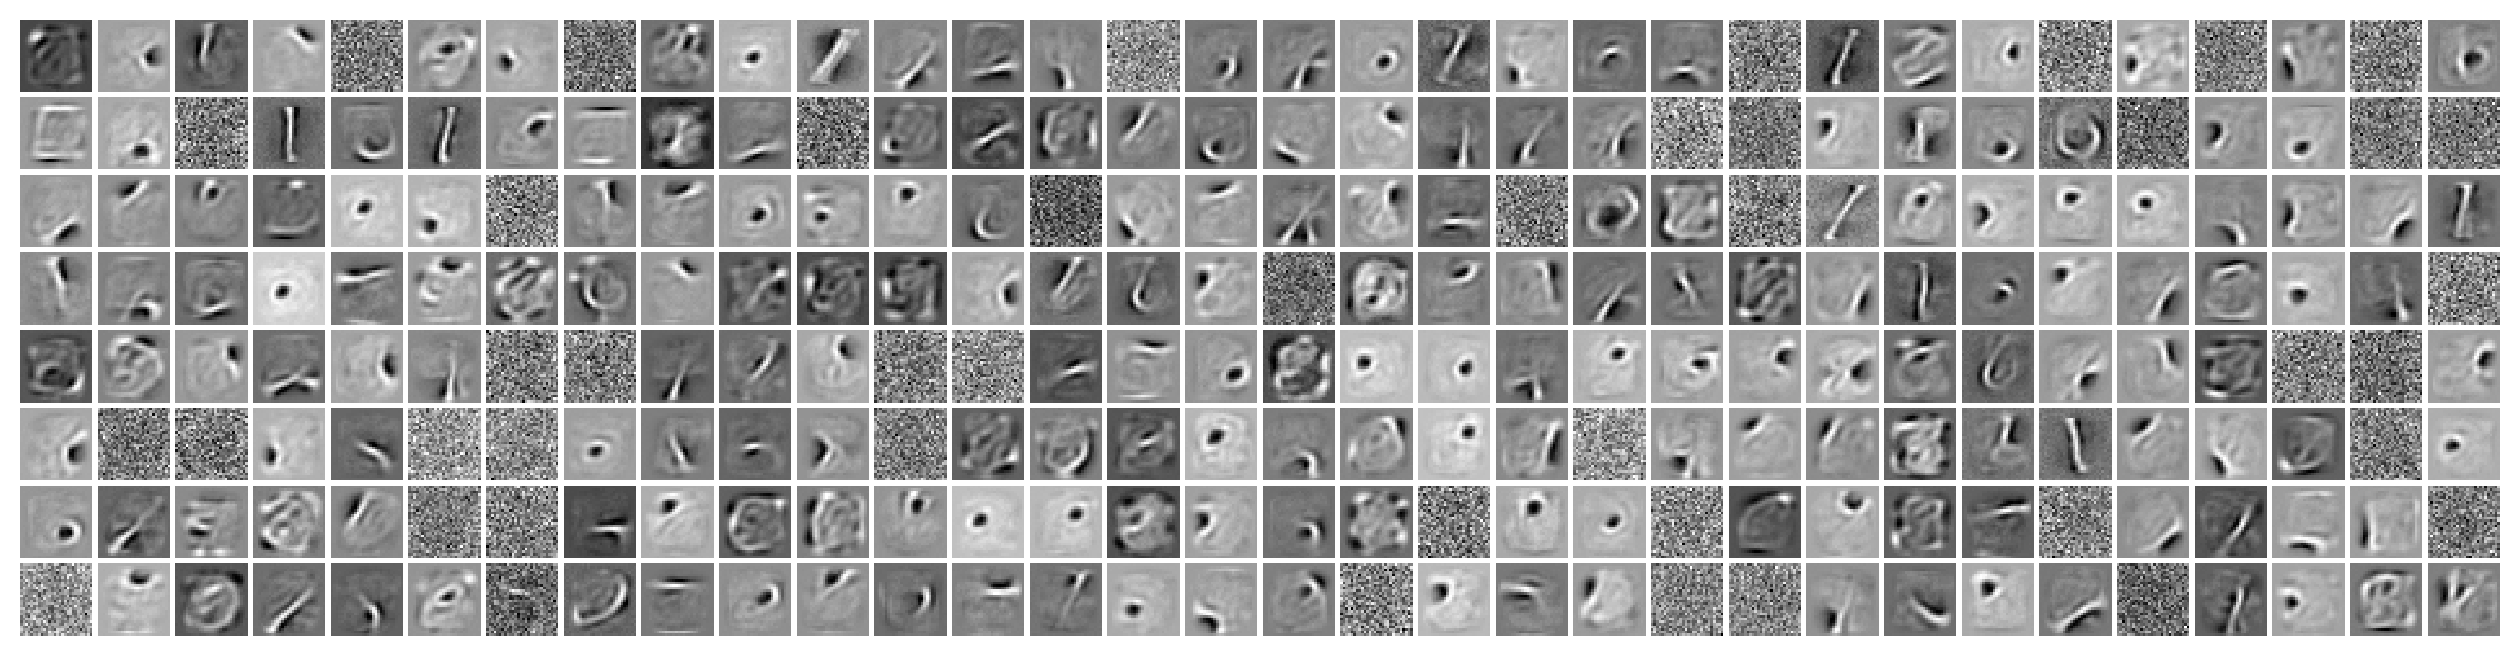

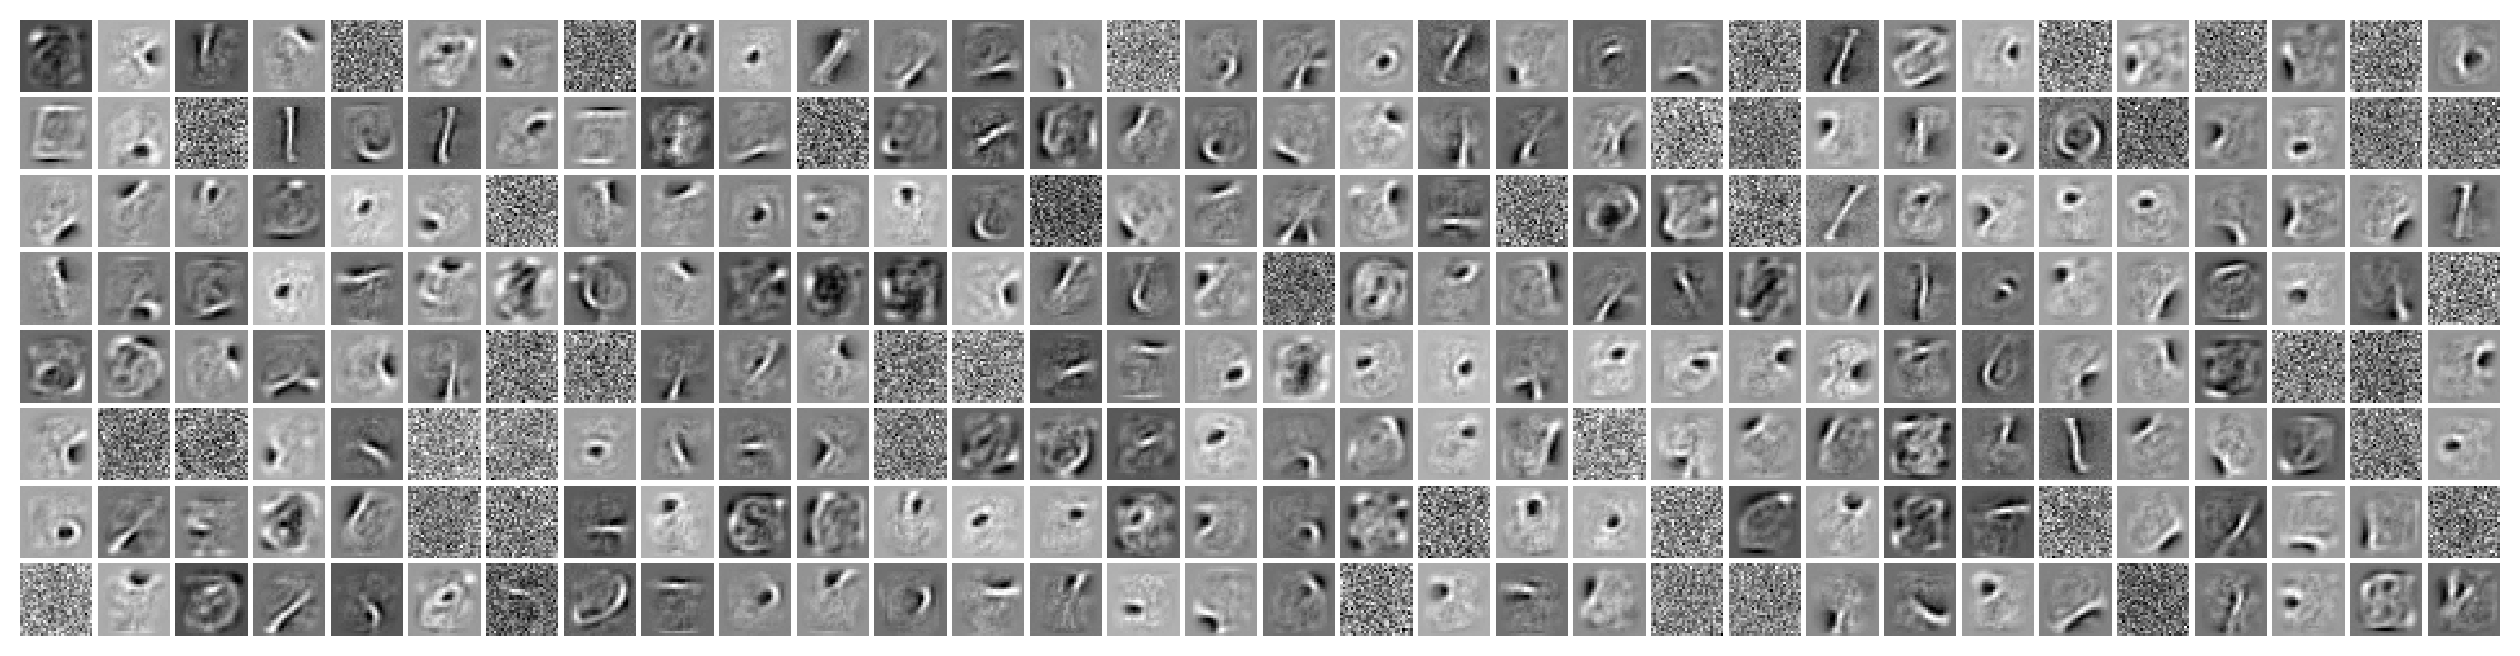

	layer 1: 2.00
	layer 2: 1.00
	layer 3: 1.00
	layer 4: 4.00


In [25]:
deep_mlp = [
    Linear(VISIBLE_LAYER_SIZE, HIDDEN_LAYER_SIZE, MLP_LEARNING_RATE, MOMENTUM, weight_limit=2.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, HIDDEN_LAYER_SIZE, MLP_LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Linear(HIDDEN_LAYER_SIZE, 2 * HIDDEN_LAYER_SIZE, MLP_LEARNING_RATE, MOMENTUM, weight_limit=1.0, init_method="He"),
    ReLU(),
    Linear(2 * HIDDEN_LAYER_SIZE, 10, SOFTMAX_LEARNING_RATE, MOMENTUM, weight_limit=4.0, init_method="He"),
]

deep_dbn = [
    RBM(
        VISIBLE_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        sigmoid,
        relu,
        RBM_LEARNING_RATE,
        MOMENTUM,
        weight_limit=2.0,
        init_method="He",
    ),
    RBM(
        HIDDEN_LAYER_SIZE,
        HIDDEN_LAYER_SIZE,
        relu,
        relu,
        RBM_LEARNING_RATE,
        MOMENTUM,
        weight_limit=1.0,
        init_method="He",
    ),
    RBM(
        HIDDEN_LAYER_SIZE,
        2 * HIDDEN_LAYER_SIZE,
        relu,
        relu,
        RBM_LEARNING_RATE,
        MOMENTUM,
        weight_limit=1.0,
        init_method="He",
    ),
]

compare_pretraining_results(
    deep_mlp,
    deep_dbn,
    mnist_train_images,
    mnist_train_labels,
    mnist_test_images,
    mnist_test_labels,
    monitoring_set,
    BATCH_SIZE,
    EPOCHS_COUNT,
)